
EE4414 Team Practice
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




In [ ]:
%matplotlib inline

: 

In [8]:
from __future__ import print_function, division

from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy

torch.manual_seed(0) # set seed to generate weights, for comparisons across different models
plt.ion()   # interactive mode

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [5]:
# Define the dataset class
directory = '\data\sg_food'
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [25]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet prior
    ])
}

data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val', 'test': 'test'}

# Define the dataset
selected_classes = [1,2,6,7,9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [7, 8, 9, 10, 11]
    name: ['Oyster Omelette', 'Roast Meat Rice', 'Roti Prata', 'Satay', 'Wanton Mee']


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



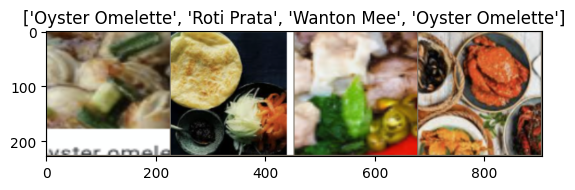

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [9]:
def train_model(model, criterion, optimizer, scheduler, early_stop_patience, num_epochs):
    # TODO
    model = model.to(device)
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler:
                            scheduler.step(loss)
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model if validation loss has improved
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_weights = copy.deepcopy(model.state_dict())
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                
                # Reduce learning rate on plateau
                if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                    
                # Early stopping
                if epochs_without_improvement >= early_stop_patience:
                    print(f'Early stopping after {epoch+1} epochs with no improvement.')
                    model.load_state_dict(best_model_weights)
                    return model
                
    return model

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [11]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model = models.resnet18(pretrained=True)

# 2. Modify the pretrain model for your task.

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # Modify output layer for 5 classes

# 3. Choose your loss function, optimizer, etc.

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)




### 4.2 Printing and visualizing the modified model

In [12]:
# TODO
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# TODO
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

In [18]:
# TODO 
start_time = time.time()
trained_model = train_model(model, criterion, optimizer, scheduler,  early_stop_patience=5, num_epochs=20)
end_time = time.time()
training_time_seconds = end_time - start_time
print(f"Total training time: {training_time_seconds:.2f} seconds")

Epoch 1/20
----------
Train Loss: 1.0229 Acc: 0.6220
Val Loss: 4.7946 Acc: 0.5133
Epoch 2/20
----------
Train Loss: 0.7507 Acc: 0.7260
Val Loss: 11.9392 Acc: 0.3267
Epoch 3/20
----------
Train Loss: 0.6916 Acc: 0.7760
Val Loss: 2.4650 Acc: 0.5867
Epoch 4/20
----------
Train Loss: 0.8089 Acc: 0.7400
Val Loss: 1.1073 Acc: 0.7267
Epoch 5/20
----------
Train Loss: 0.7717 Acc: 0.7560
Val Loss: 0.7955 Acc: 0.7667
Epoch 6/20
----------
Train Loss: 0.6755 Acc: 0.7800
Val Loss: 0.7234 Acc: 0.7800
Epoch 7/20
----------
Train Loss: 0.7848 Acc: 0.7680
Val Loss: 0.6938 Acc: 0.7800
Epoch 8/20
----------
Train Loss: 0.7689 Acc: 0.7480
Val Loss: 0.6831 Acc: 0.7800
Epoch 9/20
----------
Train Loss: 0.6945 Acc: 0.7700
Val Loss: 0.6939 Acc: 0.7800
Epoch 10/20
----------
Train Loss: 0.7623 Acc: 0.7700
Val Loss: 0.7087 Acc: 0.7800
Epoch 11/20
----------
Train Loss: 0.6180 Acc: 0.7980
Val Loss: 0.6858 Acc: 0.7800
Epoch 12/20
----------
Train Loss: 0.7293 Acc: 0.7640
Val Loss: 0.6846 Acc: 0.7800
Epoch 13/20


## 5. Loading test data

Define the dataset and dataloader for testing.

In [19]:
test_dir = os.path.join('data', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

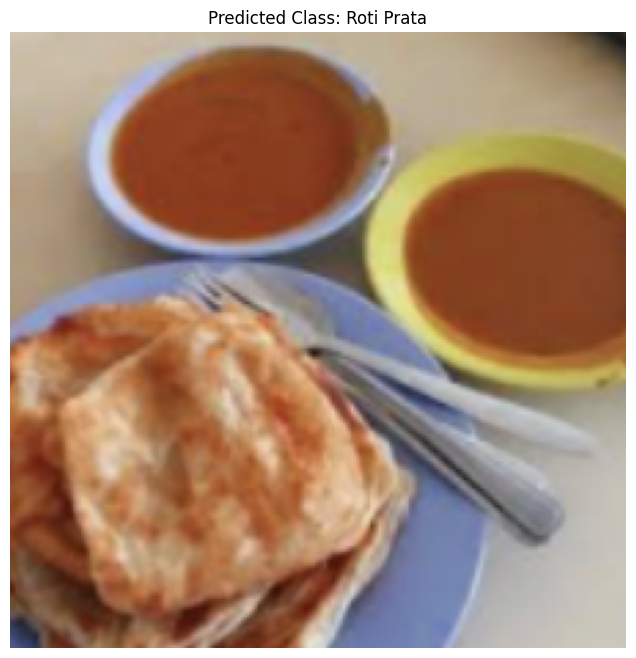

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


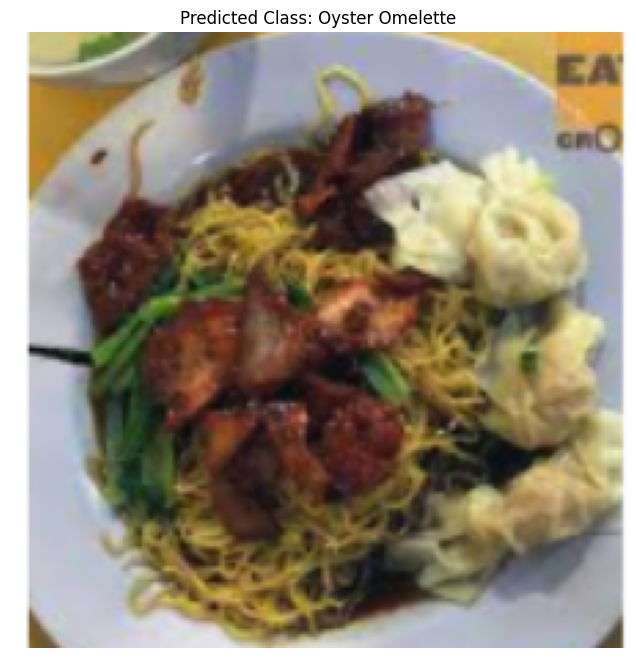

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


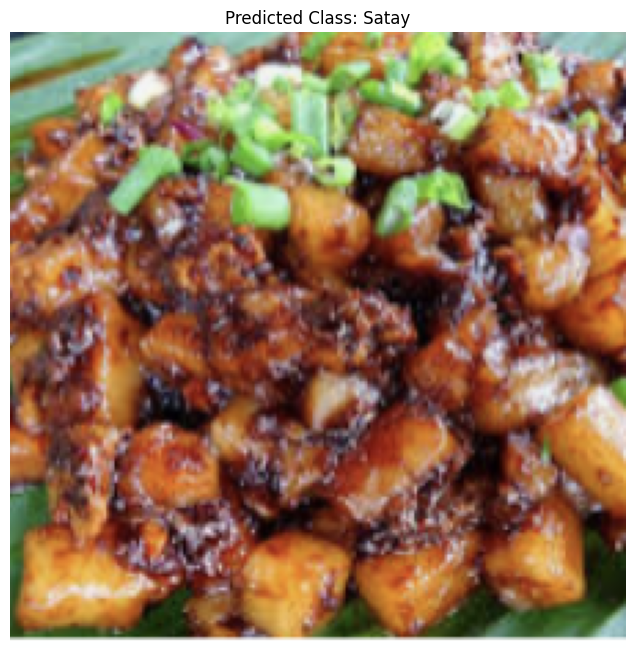

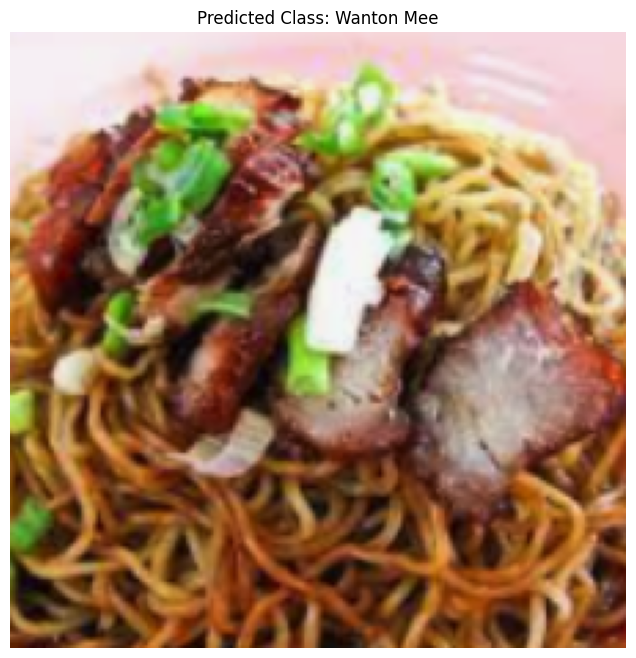

In [27]:
# TODO

# Define the number of images to predict
num_images = 4

test_loader = dataloaders['test']  # Use 'val' DataLoader as an example

# Set the model to evaluation mode
trained_model.eval()

# Iterate through the test dataloader to get the specified number of images
with torch.no_grad():
    count = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
        
        # Forward pass (make predictions)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Iterate over each image in the batch
        for i in range(inputs.size(0)):
            count += 1
            
            # Get the predicted label and convert to class name
            pred_label = preds[i].item()
            pred_class_name = class_names[pred_label]
            
            # Convert the input image tensor to numpy array for visualization
            input_image = inputs[i].cpu().numpy().transpose((1, 2, 0))
            input_image = input_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Un-normalize
            
            # Plot the image and predicted label
            plt.figure(figsize=(8, 8))
            plt.imshow(input_image)
            plt.title(f'Predicted Class: {pred_class_name}')
            plt.axis('off')
            plt.show()
            
            # Stop after predicting on the specified number of images
            if count >= num_images:
                break
        
        if count >= num_images:
            break

## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.
OOD (detect image not in all classes) should only be done on the best model

In [28]:
trained_model.eval()

test_acc = 0
ood_threshold = 0  # Adjust this threshold, 0 to disable ood detection

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Predict on the test set
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels)

        # Softmax probabilities
        softmax_probs = F.softmax(outputs, dim=1)
        max_probs, _ = torch.max(softmax_probs, dim=1)
        
        # Determine OOD samples
        ood_mask = max_probs < ood_threshold
        ood_count = torch.sum(ood_mask).item()

    # Compute the testing accuracy
    test_acc = test_acc.double() / len(test_loader.dataset)
    print('Testing Acc: {:.4f}'.format(test_acc))
    print('Out-of-Distribution Samples: {}'.format(ood_count))


Evaluation
----------
Testing Acc: 0.7778
